In [68]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score

#Configure inline and set style
%matplotlib inline
sns.set()

First step - import tablular data. Investigate for wrangling. 


In [69]:
#import raw
train_raw = pd.read_csv('../train.csv')
test_raw = pd.read_csv('../test.csv')
#make copy for wrangling
train1 = train_raw.copy(deep=True)
#put in one wrangling_set to wrangle both at once
wr_set = [train1, test_raw]

In [70]:
print(train_raw.info())
train_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


891 entries except for Age, Cabin, and Embarked.

In [71]:
print('Training Set nulls\n', train1.isnull().sum())
print('Testing Set nulls\n', test_raw.isnull().sum())

Training Set nulls
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Set nulls
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [72]:
train1.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Maenpaa, Mr. Matti Alexanteri",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


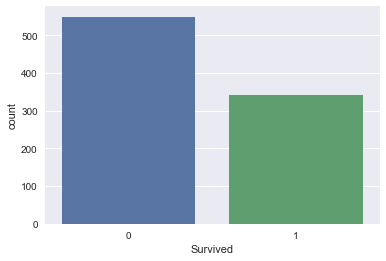

In [73]:
sns.countplot(x='Survived', data=train1);

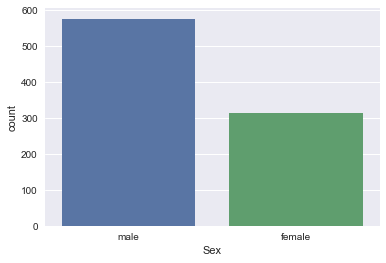

In [75]:
sns.countplot(x='Sex', data=train1);

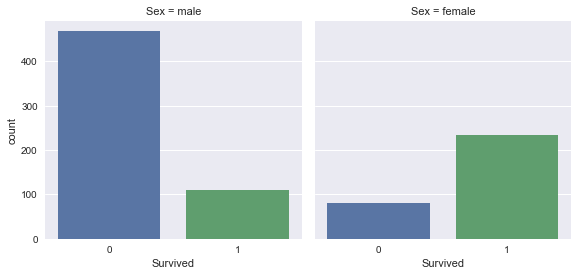

In [76]:
sns.factorplot(x='Survived', col='Sex', kind='count', data=train1);

In [77]:
train1.groupby(['Sex']).Survived.sum()

Sex
female    233
male      109
Name: Survived, dtype: int64

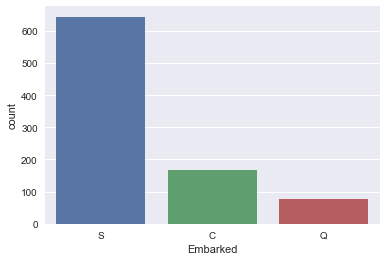

In [78]:
sns.countplot(x='Embarked', data=train1);

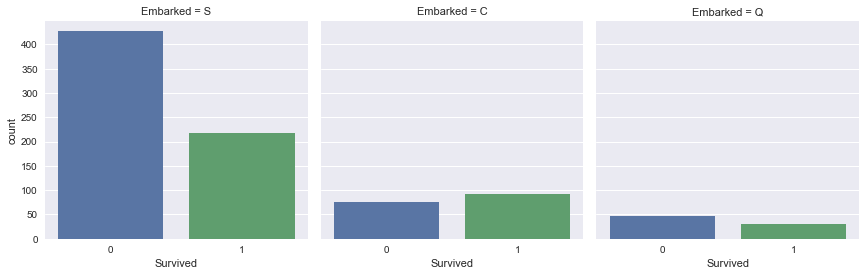

In [79]:
sns.factorplot(x='Survived', col='Embarked', kind='count', data=train1);

In [80]:
train1.groupby(['Embarked']).Survived.sum()

Embarked
C     93
Q     30
S    217
Name: Survived, dtype: int64

In [81]:
print('C: ', train1[train1.Embarked == 'C'].Survived.sum()/train1[train1.Embarked == 'C'].Survived.count())
print('Q: ', train1[train1.Embarked == 'Q'].Survived.sum()/train1[train1.Embarked == 'Q'].Survived.count())
print('S: ', train1[train1.Embarked == 'S'].Survived.sum()/train1[train1.Embarked == 'S'].Survived.count())

C:  0.5535714285714286
Q:  0.38961038961038963
S:  0.33695652173913043


To do: age, fare, cabin, embarked all contain null values.

Age- use median

Embarked- use mode

Fare- use median

Cabin- drop altogether

In [82]:
for givenset in wr_set:
    givenset['Age'].fillna(value=givenset['Age'].median(), inplace=True)
    givenset['Embarked'].fillna(value=givenset['Embarked'].mode()[0], inplace=True)
    givenset['Fare'].fillna(value=givenset['Fare'].median(), inplace=True)
    
dropcols = ['PassengerId', 'Cabin', 'Ticket']
train1.drop(dropcols, axis=1, inplace=True)

In [83]:

print('Training Set nulls\n', train1.isnull().sum())

print(test_raw.isnull().sum())

Training Set nulls
 Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


Create new data cols:

FamilySize = Parch + Sibsp + 1

IsAlone = 1 if alone, else 0 if FamilySize > 1

Title: 1 if titled, 0 if not

FareBin: 4 bins

AgeBin: 5 bins

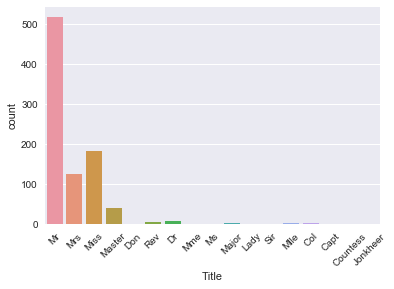

In [84]:
train1['Title'] = train1.Name.apply(lambda x: re.search('([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=train1);
plt.xticks(rotation=45);

In [ ]:
for givenset in wr_set:
    #FamilySize
    givenset['FamilySize'] = givenset['Parch']+givenset['SibSp']+1
    #IsAlone
    givenset['IsAlone'] = 1
    givenset['IsAlone'].loc[givenset['FamilySize'] > 1] =0
    #Title
    givenset['AgeBin'] = givenset['Name'].str.split(', ', )
    